In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.covariance import ledoit_wolf
import cvxpy
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position,
    get_feature_columns,
    get_symbols,
    calc_sharpe,
    calc_max_dd,
)
cloudpickle.register_pickle_by_value(src) # for model portability


os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [22]:
!pip install universal-portfolios

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.5/215.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 33.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 42.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: plotly
    Found existing installation: plotly 5.10.0
    Uninstalling plotly-5.10.0:
      Successfully uninstalled plotly-5.10.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.0
    Uninstalling seaborn-0.12.0:
      Successfully uninstalled seaborn-0.12.0
ERROR: pip's dependency resolver does not currently take 

In [18]:
from universal.algos import UP, EG, RMR, Anticor

class MyUP(UP):
    def init_step(self, X):
        rs = np.random.RandomState(1)
        m = X.shape[1]
        self.W = rs.dirichlet(np.ones(m) * 1.0, 10000)
        self.S = np.matrix(np.ones(self.W.shape[0])).T

class UniversalPortfolio:    
    def predict(self, df):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='model_id',
            values='ret'
        ).fillna(0)
        
        # algo = UP()
        algo = MyUP()
        # algo = EG(
            # eta=0.01,
            # eta=0.05,
            # eta=0.5,
        # )
        # algo = RMR()
        # algo = Anticor()
        
        
        df_x = np.maximum(0.1, 1 + df_x * 1).cumprod()
        result = algo.run(df_x)
        df_weight = result._B

        df2 = df_weight.stack()
        df['position'] = df2.loc[df.index].fillna(0)
        
        # normalize_position(df)
        return df['position']
    

In [19]:
class ExampleModelPortfolio:
    def __init__(self):
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script 
    
    def fit(self, df):
        self.symbols = get_symbols(df) # for predict script 
    
    def predict(self, df):
        df_x = df.reset_index().pivot(
            index='timestamp',
            columns='model_id',
            values='ret'
        ).fillna(0)
        
        mu_len = 12 * 24 * 30
        cov_len = 12 * 24 * 30
        
        df_weight = df_x.copy() * 0
        for i in range(1, df_x.shape[0]):
            # if df_x.index[i].hour % 2 != 1:
                # continue
                
            max_i = i - 1
                
            df_cov = df_x.iloc[max(0, max_i - cov_len + 1):max_i + 1]
            S, _ = ledoit_wolf(df_cov)  
            
            mu = df_x.iloc[max(0, max_i - mu_len + 1):max_i + 1].mean(axis=0)

            weight = optimize_mv(
                mu=mu, 
                S=S, 
                target_std=0.04 / (24 ** 0.5), 
                # max_total_pos=1.0
            )
            df_weight.iloc[i, :] = weight
        
        df2 = df_weight.stack()
        df['position'] = df2.loc[df.index].fillna(0)
        
#         normalize_position(df)
        return df['position']
    
def optimize_mv(mu=None, S=None, target_std=None, max_total_pos=None):
    mem = get_joblib_memory()
    return mem.cache(do_optimize_mv)(mu=mu, S=S, target_std=target_std, max_total_pos=max_total_pos)

def do_optimize_mv(mu=None, S=None, target_std=None, max_total_pos=None):
    x = cvxpy.Variable(mu.shape[0])
    S = np.array(S)
    mu = np.array(mu)

    objective = cvxpy.Minimize(-mu @ x)
    constraints = [
        cvxpy.quad_form(x, S) <= target_std ** 2,
        # x >= 0,
    ]
    
    if max_total_pos is not None:
        constraints += [
            cvxpy.sum(cvxpy.abs(x)) <= max_total_pos,
        ]

    prob = cvxpy.Problem(objective, constraints)

    try:
        result = prob.solve()
        weight = x.value
        if weight is None:
            print('weight is None')
            weight = np.zeros(mu.size)
    except Exception as e:
        print(e)
        weight = np.zeros(mu.size)

    return weight

In [20]:
def visualize_result(df, symbol_col='symbol', execution_cost=0.001):
    df = df.copy()

    # calc return
    df["ret_pos"] = df["ret"] * df["position"]
    df["hour"] = df.index.get_level_values("timestamp").hour
    df["position_prev"] = df.groupby(["hour", symbol_col])["position"].shift(1).fillna(0)
    df["cost"] = (df["position"] - df["position_prev"]).abs() * execution_cost
    df["ret_pos_cost"] = df["ret_pos"] - df["cost"]

    # print statistics
    for with_cost in [False, True]:
        if with_cost:
            print("return with cost statistics")
            x = df.groupby("timestamp")["ret_pos_cost"].sum()
        else:
            print("return without cost statistics")
            x = df.groupby("timestamp")["ret_pos"].sum()

        print("mean {}".format(np.mean(x)))
        print("std {}".format(np.std(x)))
        print("sharpe {}".format(calc_sharpe(x)))
        print("max drawdown {}".format(calc_max_dd(x)))

    # plot ret
    for symbol, df_symbol in df.groupby(symbol_col):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        df_symbol["ret"].cumsum().plot(label=symbol)
        # df_symbol["ret_pos_cost"].cumsum().plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("return with cost by symbol")
    plt.show()

    # plot position
    for symbol, df_symbol in df.groupby(symbol_col):
        df_symbol = df_symbol.reset_index().set_index("timestamp")
        df_symbol["position"].plot(label=symbol)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("position by symbol")
    plt.show()

    # plot total ret
    df.groupby("timestamp")["ret_pos"].sum().cumsum().plot(label="ret without cost")
    # df.groupby("timestamp")["ret_pos_cost"].sum().cumsum().plot(label="ret with cost")
    # df.groupby("timestamp")["cost"].sum().cumsum().plot(label="cost")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.title("total return")
    plt.show()


ret
timestamp           model_id                         
2022-09-02 01:05:00 example-model-portfolio -0.000031
                    example-model-rank      -0.000054
                    example-model-rank2      0.000000
                    example-model-rank3      0.000000
                    m-20220904-nn            0.000000
...                                               ...
2022-09-30 09:55:00 m-20220921-remove-feat   0.001140
                    m-20220928-btc-beta      0.001150
                    m-20220929-btc-beta-one  0.000847
                    pf-universal             0.000765
                    pf-universal2            0.001950

[233642 rows x 1 columns]

return without cost statistics
mean 2.533240062027044e-06
std 0.00032099309193212375
sharpe 0.007891883425836204
max drawdown 0.008435477431694335
return with cost statistics
mean -4.248312056055678e-07
std 0.0003237596810069912
sharpe -0.0013121807023166484
max drawdown 0.008435462101942603


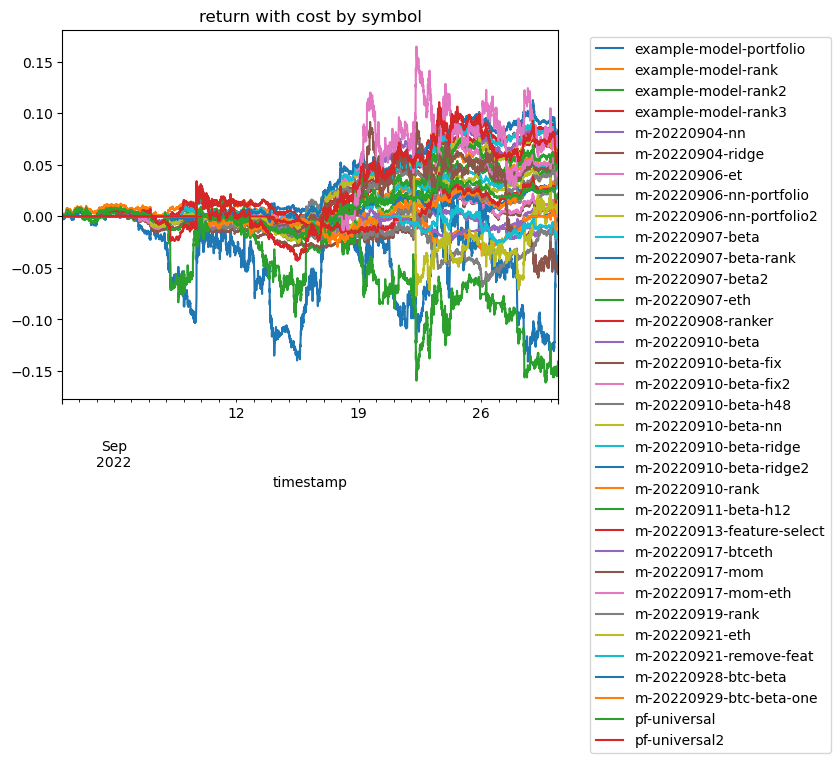

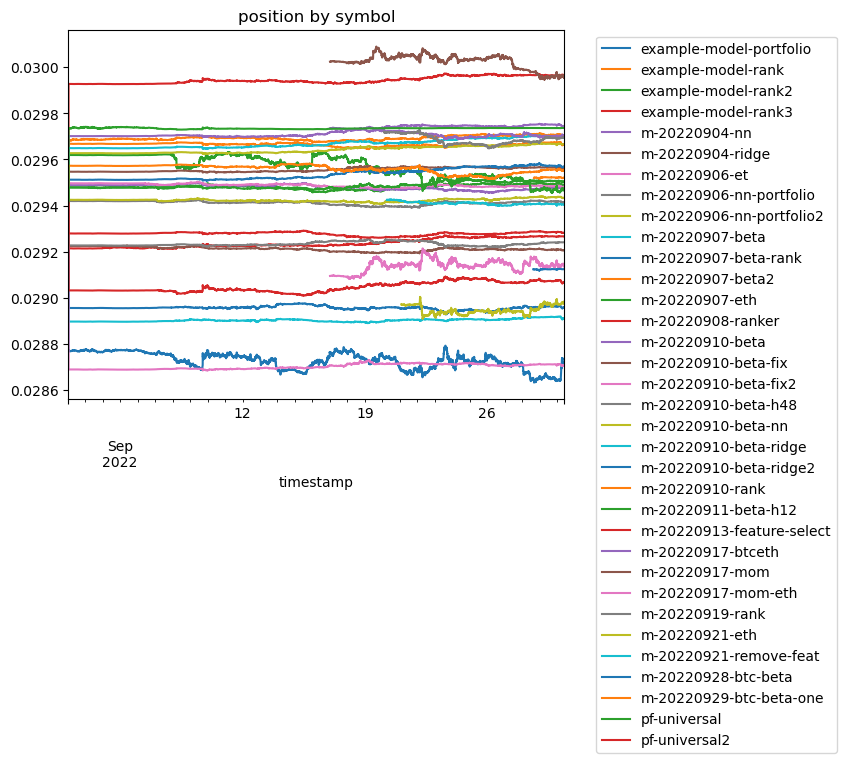

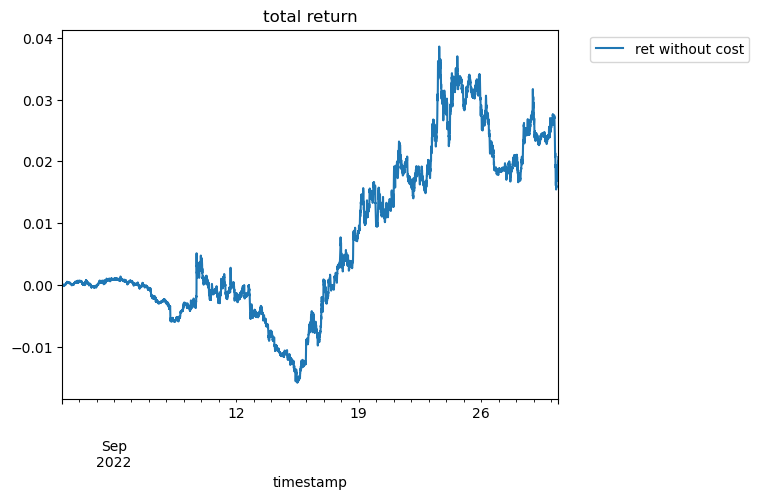

In [21]:
df = pd.read_parquet('/home/jovyan/data/20220930_returns.parquet')
display(df)

# model = ExampleModelPortfolio()
model = UniversalPortfolio()

df['pos'] = model.predict(df)
visualize_result(df.dropna(), symbol_col='model_id')